In [1]:
# ==============================================================
# CVAE + FiLM + Latent Quantization + Advanced Evaluation
# ==============================================================

import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from tqdm import tqdm
import numpy as np
import random
from collections import defaultdict
from glob import glob
from PIL import Image
import lpips
import matplotlib.pyplot as plt
import timm
import pandas as pd # ✅ Added for robust binning
from sklearn.linear_model import LogisticRegression


# ✅ Metrics Imports
from sklearn.metrics import silhouette_score, mutual_info_score
from scipy.stats import entropy

# --- 1. Configuration & Hyperparameters ---

GPU_ID = 0
DEVICE = torch.device(f'cuda:{GPU_ID}' if torch.cuda.is_available() else 'cpu')

DATA_DIR = '/home/juhyeong/AML/Data'
CVAE_MODEL_PATH = "best_cvae_quantization_hyperparameter.pth"

IMAGE_SIZE = 224
IMAGE_CHANNEL = 1
LATENT_DIM = 128
CLASSES = {0: 'Non Demented', 1: 'Very mild Dementia', 2: 'Mild Dementia'}
NUM_CLASSES = len(CLASSES)
CLASS_NAMES_MAP = {v: k for k, v in CLASSES.items()}
NUM_EPOCHS = 50
LEARNING_RATE = 1e-5
BATCH_SIZE = 32

# Loss weights
BETA_KLD_WEIGHT = 2.0
BCE_WEIGHT = 1.0
LAMBDA_LPIPS = 2.0
W_CENTER = 10.0
W_SEPARATION = 5.0
MARGIN = 2.0

# Updated for Latent Quantization
WEIGHT_DECAY = 1e-2       # Increased from 1e-5 (Crucial for QLAE [cite: 57])
LAMBDA_QUANT = 5.0        # Weight for quantization losses
LAMBDA_COMMIT = 1.0       # Standard weighting for commitment (beta)

# Classifier-guided loss
CLASSIFIER_LOSS_WEIGHT = 3.0

OUTPUT_FOLDER = "GEN_SAMPLES_QUANTIZATION_HYPERPARAMETER"
os.makedirs(OUTPUT_FOLDER, exist_ok=True)

transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()
])


# ---------------------------------------------------------------
# Pretrained Classifier
# ---------------------------------------------------------------

class SimpleClassifier(nn.Module):
    def __init__(self, model_name='resnet18', num_classes=NUM_CLASSES):
        super().__init__()
        self.model = timm.create_model(
            model_name,
            pretrained=False,
            num_classes=num_classes,
            in_chans=1
        )

    def forward(self, x):
        return self.model(x)


def load_classifier(path="/home/juhyeong/AML/best_classifier_resnet18_weights_42.pth"):
    cls = SimpleClassifier(num_classes=NUM_CLASSES).to(DEVICE)
    ckpt = torch.load(path, map_location=DEVICE)
    cls.load_state_dict(ckpt)
    cls.eval()
    for p in cls.parameters():
        p.requires_grad = False
    return cls


# ---------------------------------------------------------------
# Scalar Quantizer Module
# ---------------------------------------------------------------

class ScalarQuantizer(nn.Module):
    def __init__(self, num_latents, num_levels=5):
        super().__init__()
        self.num_latents = num_latents
        self.num_levels = num_levels
        init_vals = torch.linspace(-0.5, 0.5, num_levels)
        self.codebooks = nn.Parameter(init_vals.unsqueeze(0).repeat(num_latents, 1))
        
    def forward(self, z_continuous):
        B, D = z_continuous.shape
        z_expanded = z_continuous.unsqueeze(-1)
        codes_expanded = self.codebooks.unsqueeze(0)
        dists = torch.abs(z_expanded - codes_expanded)
        min_indices = torch.argmin(dists, dim=-1)
        
        indices_expanded = min_indices.unsqueeze(-1)
        codes_batch = codes_expanded.expand(B, -1, -1)
        z_q = torch.gather(codes_batch, 2, indices_expanded).squeeze(-1)
        
        z_q_detached = z_q.detach()
        z_c_detached = z_continuous.detach()
        loss_quantize = F.mse_loss(z_q, z_c_detached)
        loss_commit = F.mse_loss(z_q_detached, z_continuous)

        z_out = z_continuous + (z_q - z_continuous).detach()
        return z_out, loss_quantize, loss_commit, min_indices


# ---------------------------------------------------------------
# Dataset
# ---------------------------------------------------------------

class OASISContrastiveDataset(Dataset):
    def __init__(self, root_dir, transform=None, split='train', val_ratio=0.2, seed=42):
        self.transform = transform
        self.root_dir = root_dir
        self.data = []

        subject_to_imgs = defaultdict(list)

        for class_folder in os.listdir(root_dir):
            if class_folder not in CLASS_NAMES_MAP:
                continue
            class_label = CLASS_NAMES_MAP[class_folder]
            for img_path in glob(os.path.join(root_dir, class_folder, "*.jpg")):
                name = os.path.basename(img_path).split('.')[0]
                parts = name.split('_')
                subj = parts[1] if len(parts) > 1 else name
                subject_to_imgs[subj].append((img_path, class_label))

        self.subject_to_imgs = subject_to_imgs

        subject_main_label = {}
        for subj, items in subject_to_imgs.items():
            labels = [lbl for _, lbl in items]
            subject_main_label[subj] = max(set(labels), key=labels.count)

        random.seed(seed)
        class_to_subjects = defaultdict(list)
        for subj, lbl in subject_main_label.items():
            class_to_subjects[lbl].append(subj)

        train_subjects, val_subjects = [], []
        for lbl, subj_list in class_to_subjects.items():
            random.shuffle(subj_list)
            n_val = int(len(subj_list) * val_ratio)
            val_subjects.extend(subj_list[:n_val])
            train_subjects.extend(subj_list[n_val:])

        self.train_subjects = sorted(train_subjects)
        self.val_subjects = sorted(val_subjects)

        chosen = train_subjects if split == 'train' else val_subjects
        for subj in chosen:
            for img_path, lbl in subject_to_imgs[subj]:
                self.data.append((subj, img_path, lbl))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        subj, img_path, y = self.data[idx]
        img = Image.open(img_path).convert("L")
        if self.transform:
            img = self.transform(img)
        return img, y, subj


# ---------------------------------------------------------------
# Improved Latent Clustering Loss
# ---------------------------------------------------------------

class ImprovedClusteringLoss(nn.Module):
    def __init__(self, latent_dim: int, num_classes: int, margin: float = 2.0):
        super().__init__()
        self.num_classes = num_classes
        self.margin = margin
        self.centers = nn.Parameter(torch.randn(num_classes, latent_dim))
        nn.init.xavier_uniform_(self.centers)

    def forward(self, features: torch.Tensor, labels: torch.Tensor):
        centers_batch = self.centers[labels]
        center_loss = F.mse_loss(features, centers_batch)

        separation_loss = 0
        num_pairs = 0
        for i in range(self.num_classes):
            for j in range(i + 1, self.num_classes):
                dist = F.pairwise_distance(
                    self.centers[i].unsqueeze(0),
                    self.centers[j].unsqueeze(0)
                )
                separation_loss += F.relu(self.margin - dist)
                num_pairs += 1

        if num_pairs > 0:
            separation_loss = separation_loss / num_pairs

        return center_loss, separation_loss


# ---------------------------------------------------------------
# CVAE Model Components
# ---------------------------------------------------------------

class FiLMCond(nn.Module):
    def __init__(self, embed_dim, num_features):
        super().__init__()
        self.scale = nn.Linear(embed_dim, num_features)
        self.shift = nn.Linear(embed_dim, num_features)

    def forward(self, h, class_emb):
        gamma = self.scale(class_emb).unsqueeze(-1).unsqueeze(-1)
        beta = self.shift(class_emb).unsqueeze(-1).unsqueeze(-1)
        return h * (1 + gamma) + beta

def up_block(cin, cout):
    return nn.Sequential(
        nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
        nn.Conv2d(cin, cout, 3, 1, 1),
        nn.BatchNorm2d(cout),
        nn.ReLU(inplace=True),
    )

class ImprovedCVAE(nn.Module):
    def __init__(self, latent_dim, img_size, img_channel, num_classes):
        super().__init__()

        self.latent_dim = latent_dim
        self.cls_dim = 32                      
        self.content_dim = latent_dim - self.cls_dim 

        self.enc_conv1 = nn.Sequential(nn.Conv2d(img_channel, 32, 4, 2, 1), nn.BatchNorm2d(32), nn.ReLU())
        self.enc_conv2 = nn.Sequential(nn.Conv2d(32, 64, 4, 2, 1), nn.BatchNorm2d(64), nn.ReLU())
        self.enc_conv3 = nn.Sequential(nn.Conv2d(64, 128, 4, 2, 1), nn.BatchNorm2d(128), nn.ReLU())
        self.enc_conv4 = nn.Sequential(nn.Conv2d(128, 256, 4, 2, 1), nn.BatchNorm2d(256), nn.ReLU())

        self.flat = 256 * 14 * 14
        
        self.fc_class_mu = nn.Linear(self.flat, self.cls_dim)
        self.fc_class_logv = nn.Linear(self.flat, self.cls_dim)

        self.fc_content_pre = nn.Linear(self.flat, self.content_dim)
        self.quantizer = ScalarQuantizer(self.content_dim, num_levels=10)

        self.class_embed = nn.Embedding(num_classes, self.cls_dim)

        self.film1 = FiLMCond(self.cls_dim, 128)
        self.film2 = FiLMCond(self.cls_dim, 64)
        self.film3 = FiLMCond(self.cls_dim, 32)

        self.dec_fc = nn.Linear(latent_dim, self.flat)
        self.dec1 = up_block(256 + 128, 128)
        self.dec2 = up_block(128 + 64, 64)
        self.dec3 = up_block(64, 32)
        self.out = nn.Sequential(nn.Conv2d(32, 1, 3, 1, 1), nn.Sigmoid())

    def reparam(self, mu, logv):
        std = (0.5 * logv).exp()
        return mu + torch.randn_like(std) * std

    def forward(self, x, class_label):
        e1 = self.enc_conv1(x)
        e2 = self.enc_conv2(e1)
        e3 = self.enc_conv3(e2)
        e4 = self.enc_conv4(e3)

        h = e4.view(x.size(0), -1)
        
        class_mu = self.fc_class_mu(h)
        class_logv = self.fc_class_logv(h)
        z_class_raw = self.reparam(class_mu, class_logv)

        z_content_continuous = self.fc_content_pre(h)
        z_content, q_loss, c_loss, _ = self.quantizer(z_content_continuous)

        class_emb = self.class_embed(class_label)
        z_final = torch.cat([z_content, class_emb], dim=1)

        d = self.dec_fc(z_final).view(x.size(0), 256, 14, 14)
        d = F.interpolate(d, size=e3.shape[2:], mode="bilinear")
        d = self.dec1(torch.cat([d, e3], dim=1))
        d = self.film1(d, class_emb)

        d = F.interpolate(d, size=e2.shape[2:], mode="bilinear")
        d = self.dec2(torch.cat([d, e2], dim=1))
        d = self.film2(d, class_emb)

        d = F.interpolate(d, size=(112, 112), mode="bilinear")
        d = self.dec3(d)
        d = self.film3(d, class_emb)

        out = self.out(F.interpolate(d, size=(224, 224), mode="bilinear"))

        return out, class_mu, class_logv, z_content, z_class_raw, q_loss, c_loss


# ---------------------------------------------------------------
# Helpers
# ---------------------------------------------------------------
lpips_fn = lpips.LPIPS(net='alex').to(DEVICE)
for p in lpips_fn.parameters():
    p.requires_grad = False

@torch.no_grad()
def validate(model, loader, lambda_recon, beta, clustering_loss_fn, classifier):
    model.eval()
    total = 0
    sum_loss = 0

    for x, y, _ in loader:
        x = x.to(DEVICE)
        y = y.to(DEVICE)

        recon, cls_mu, cls_logv, z_content, z_class_raw, q_loss, c_loss = model(x, y)

        bce = F.binary_cross_entropy(recon, x, reduction='mean')
        lp = lpips_fn(recon.repeat(1, 3, 1, 1), x.repeat(1, 3, 1, 1)).mean()
        kld = -0.5 * torch.mean(1 + cls_logv - cls_mu.pow(2) - cls_logv.exp())
        center_loss, sep_loss = clustering_loss_fn(z_class_raw, y)
        quant_term = LAMBDA_QUANT * (q_loss + LAMBDA_COMMIT * c_loss)

        recon_norm = (recon - 0.456) / 0.224
        cls_logits = classifier(recon_norm)
        cls_loss = F.cross_entropy(cls_logits, y)

        loss = (lambda_recon * bce +
                beta * kld +
                LAMBDA_LPIPS * lp +
                W_CENTER * center_loss +
                W_SEPARATION * sep_loss +
                CLASSIFIER_LOSS_WEIGHT * cls_loss +
                quant_term)

        bs = x.size(0)
        total += bs
        sum_loss += loss.item() * bs

    return sum_loss / total


# ---------------------------------------------------------------
# Training Loop
# ---------------------------------------------------------------
def train_improved_cvae(model, train_loader, val_loader, epochs, lr, lambda_recon, beta_max, classifier):
    opt = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=WEIGHT_DECAY) 
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=epochs)

    clustering_loss_fn = ImprovedClusteringLoss(
        latent_dim=model.cls_dim,
        num_classes=NUM_CLASSES,
        margin=MARGIN
    ).to(DEVICE)

    best_val = 1e9
    patience = 10
    no_improve = 0

    for epoch in range(1, epochs + 1):
        model.train()
        beta = min(beta_max, beta_max * epoch / max(1, epochs // 2))

        pbar = tqdm(train_loader, desc=f"Epoch {epoch}/{epochs}")
        for x, y, _ in pbar:
            x = x.to(DEVICE)
            y = y.to(DEVICE)

            opt.zero_grad()
            recon, cls_mu, cls_logv, z_content, z_class_raw, q_loss, c_loss = model(x, y)

            bce = F.binary_cross_entropy(recon, x, reduction='mean')
            lp = lpips_fn(recon.repeat(1, 3, 1, 1), x.repeat(1, 3, 1, 1)).mean()
            kld = -0.5 * torch.mean(1 + cls_logv - cls_mu.pow(2) - cls_logv.exp())
            quant_term = LAMBDA_QUANT * (q_loss + LAMBDA_COMMIT * c_loss)
            center_loss, sep_loss = clustering_loss_fn(z_class_raw, y)

            recon_norm = (recon - 0.456) / 0.224
            cls_logits = classifier(recon_norm)
            cls_loss_val = F.cross_entropy(cls_logits, y)

            loss = (lambda_recon * bce +
                    beta * kld +
                    LAMBDA_LPIPS * lp +
                    W_CENTER * center_loss +
                    W_SEPARATION * sep_loss +
                    CLASSIFIER_LOSS_WEIGHT * cls_loss_val +
                    quant_term)

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            opt.step()

            pbar.set_postfix({
                "loss": f"{loss.item():.3f}",
                "q_loss": f"{q_loss.item():.3f}",
                "cls": f"{cls_loss_val.item():.3f}"
            })

        scheduler.step()
        val_loss = validate(model, val_loader, lambda_recon, beta, clustering_loss_fn, classifier)
        print(f"\n====> Epoch {epoch}/{epochs} | Val Loss {val_loss:.4f}")

        if val_loss < best_val:
            best_val = val_loss
            torch.save({
                "model": model.state_dict(),
                "cluster": clustering_loss_fn.state_dict(),
                "epoch": epoch,
                "val_loss": val_loss
            }, CVAE_MODEL_PATH)
            print("🔥 Saved best model\n")
            no_improve = 0
        else:
            no_improve += 1
            if no_improve >= patience:
                print("Early stopping")
                break

    return clustering_loss_fn


# ---------------------------------------------------------------
# ✅ ADVANCED DISENTANGLEMENT EVALUATION
# ---------------------------------------------------------------

def discretize_latents(data, bins=20):
    """
    Discretizes continuous latent codes into bins for discrete entropy calculation.
    Uses quantile binning (qcut) to handle outliers/distributions robustly.
    """
    discretized = np.zeros_like(data, dtype=int)
    for i in range(data.shape[1]):
        discretized[:, i] = pd.qcut(data[:, i], q=bins, labels=False, duplicates='drop')
    return discretized

# ---------------------------------------------------------------
# 3. THE METRICS FUNCTION (REQUIRED)
# ---------------------------------------------------------------

def calculate_advanced_metrics(model, loader, device):
    model.eval()
    
    z_full_list, z_class_list, labels_list = [], [], []
    
    print("\n[Advanced Eval] Extracting latents...")
    with torch.no_grad():
        for x, y, _ in tqdm(loader, desc="Encoding"):
            x = x.to(device)
            y = y.to(device)
            
            # Unpack 7 values for Quantized model
            _, _, _, z_content, z_class_raw, _, _ = model(x, y)
            
            z_full = torch.cat([z_content, z_class_raw], dim=1)
            z_full_list.append(z_full.cpu().numpy())
            z_class_list.append(z_class_raw.cpu().numpy())
            labels_list.append(y.cpu().numpy())
            
    Z_full = np.concatenate(z_full_list, axis=0)
    Z_class = np.concatenate(z_class_list, axis=0)
    Y = np.concatenate(labels_list, axis=0)
    
    # 1. Silhouette
    print("  - Calculating Silhouette Score...")
    if len(Y) > 10000:
        indices = np.random.choice(len(Y), 10000, replace=False)
        sil_score = silhouette_score(Z_class[indices], Y[indices])
    else:
        sil_score = silhouette_score(Z_class, Y)

    # 2. MIG
    print("  - Calculating MIG...")
    discretized = np.zeros_like(Z_full, dtype=int)
    for i in range(Z_full.shape[1]):
        discretized[:, i] = pd.qcut(Z_full[:, i], q=20, labels=False, duplicates='drop')
    num_latents = Z_full.shape[1]
    _, counts = np.unique(Y, return_counts=True)
    entropy_y = entropy(counts)
    mi_scores = []
    for j in range(num_latents):
        mi = mutual_info_score(discretized[:, j], Y)
        mi_scores.append(mi)
    mi_scores = np.array(mi_scores)
    sorted_mi = np.sort(mi_scores)[::-1]
    mig_score = (sorted_mi[0] - sorted_mi[1]) / entropy_y if entropy_y > 0 else 0

    # 3. Modularity
    print("  - Calculating Modularity...")
    content_dim = Z_full.shape[1] - Z_class.shape[1] 
    mi_class = mi_scores[content_dim:]
    mi_content = mi_scores[:content_dim]
    
    # Explicit variables for printing
    total_info_class = np.sum(mi_class)
    total_info_content = np.sum(mi_content)
    
    modularity_ratio = total_info_class / (total_info_class + total_info_content + 1e-8)

    # 4. Linear Modularity + PLOTTING
    print("  - Generating Plot...")
    clf = LogisticRegression(max_iter=2000, solver='liblinear')
    clf.fit(Z_class, Y)
    avg_coefs = np.mean(np.abs(clf.coef_), axis=0) 
    lin_mod_score = np.max(avg_coefs) / (np.sum(avg_coefs) + 1e-8)
    
    top_2_idx = np.argsort(avg_coefs)[::-1][:2]
    dim_x, dim_y = top_2_idx[0], top_2_idx[1]
    
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(Z_class[:, dim_x], Z_class[:, dim_y], c=Y, cmap='viridis', alpha=0.6, s=10)
    plt.colorbar(scatter, label="Class Label")
    plt.title(f"Latent Space Separation (Dims {dim_x} & {dim_y})\n"
              f"Silhouette: {sil_score:.3f} | Linear Modularity: {lin_mod_score:.3f}")
    plt.xlabel(f"Latent Dim {dim_x}")
    plt.ylabel(f"Latent Dim {dim_y}")
    plt.grid(True, linestyle='--', alpha=0.5)
    
    save_path = os.path.join(OUTPUT_FOLDER, "linear_modularity_scatter.png")
    plt.savefig(save_path, dpi=150)
    plt.close()
    print(f"  - Saved plot to {save_path}")

    print("\n" + "="*50)
    print(f" DISENTANGLEMENT RESULTS FOR: {CVAE_MODEL_PATH}")
    print("="*50)
    print(f"1. Silhouette Score:       {sil_score:.4f}")
    print(f"2. Linear Modularity:      {lin_mod_score:.4f}")
    print(f"   (Concentration: Higher is better. 1.0 = Perfect, <0.1 = Entangled)")
    print(f"3. Mutual Info Gap (MIG):  {mig_score:.4f}")
    print(f"   (Compactness: Higher is better. Measures single-neuron control.)")
    print(f"4. Modularity (Info Ratio): {modularity_ratio:.4f}")
    print(f"   (Specialization: Ratio of Class Info in z_class vs z_content)")
    print(f"   - Info in Content (Leakage): {total_info_content:.4f}")
    print(f"   - Info in Class Latents:     {total_info_class:.4f}")
    print("="*50 + "\n")


# ---------------------------------------------------------------
# Image Generation Helpers
# ---------------------------------------------------------------
@torch.no_grad()
def generate_conditional_image(model, image, orig_label, target_label):
    model.eval()
    img = image.to(DEVICE).unsqueeze(0)
    target = torch.tensor([target_label], device=DEVICE)
    recon, _, _, _, _, _, _ = model(img, target)
    arr = (recon.squeeze().cpu().clamp(0, 1).numpy() * 255).astype(np.uint8)
    pil = Image.fromarray(arr, 'L')
    fname = f"from_{CLASSES[orig_label]}_to_{CLASSES[target_label]}_{np.random.randint(9999)}.png"
    path = os.path.join(OUTPUT_FOLDER, fname)
    pil.save(path)
    return path

@torch.no_grad()
def save_comparison(model, image, orig_label, target_label, save_path):
    model.eval()
    img = image.to(DEVICE).unsqueeze(0)
    target = torch.tensor([target_label], device=DEVICE)
    recon, _, _, _, _, _, _ = model(img, target)
    
    x0_np = image.squeeze().cpu().numpy()
    gen_np = recon.squeeze().cpu().clamp(0, 1).numpy()

    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(x0_np, cmap='gray')
    plt.title(f"Original ({CLASSES[orig_label]})", fontsize=12)
    plt.axis("off")
    plt.subplot(1, 2, 2)
    plt.imshow(gen_np, cmap='gray')
    plt.title(f"Generated ({CLASSES[target_label]})", fontsize=12)
    plt.axis("off")
    plt.tight_layout()
    plt.savefig(save_path, dpi=100)
    plt.close()
    print("\nStarting Quantization CVAE Training...")
  

/home/juhyeong/.conda/envs/cvae/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/home/juhyeong/.conda/envs/cvae/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/juhyeong/.conda/envs/cvae/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /home/juhyeong/.conda/envs/cvae/lib/python3.9/site-packages/lpips/weights/v0.1/alex.pth


In [3]:
if __name__ == "__main__":
    
    # --- CONTROL FLAGS -----------------------------------------
    TRAIN_MODE = True  
    # -----------------------------------------------------------

    # 1. Load Data
    train_dataset = OASISContrastiveDataset(DATA_DIR, transform=transform, split='train')
    val_dataset = OASISContrastiveDataset(DATA_DIR, transform=transform, split='val')

    print("\n--- Train subjects:", len(train_dataset.train_subjects))
    print("--- Val subjects:", len(val_dataset.val_subjects))

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

    # 2. Initialize Model
    model = ImprovedCVAE(
        LATENT_DIM, IMAGE_SIZE, IMAGE_CHANNEL,
        num_classes=NUM_CLASSES
    ).to(DEVICE)

    classifier = load_classifier()

    # 3. Train or Load
    if TRAIN_MODE:
        print(f"\n🚀 Starting Quantization Training (Epochs: {NUM_EPOCHS})...")
        clustering_loss_fn = train_improved_cvae(
            model, train_loader, val_loader,
            epochs=NUM_EPOCHS, lr=LEARNING_RATE,
            lambda_recon=BCE_WEIGHT, beta_max=BETA_KLD_WEIGHT,
            classifier=classifier
        )
    else:
        print(f"\n⏩ Skipping Training. Loading pre-trained model from {CVAE_MODEL_PATH}...")
        if os.path.exists(CVAE_MODEL_PATH):
            ckpt = torch.load(CVAE_MODEL_PATH, map_location=DEVICE)
            model.load_state_dict(ckpt["model"])
            # Initialize clustering loss to load its state (optional but good practice)
            clustering_loss_fn = ImprovedClusteringLoss(
                latent_dim=model.cls_dim, num_classes=NUM_CLASSES, margin=MARGIN
            ).to(DEVICE)
            if "cluster" in ckpt:
                clustering_loss_fn.load_state_dict(ckpt["cluster"])
            print(f"✅ Successfully loaded model from epoch {ckpt.get('epoch', '?')}")
        else:
            raise FileNotFoundError(f"Could not find model at {CVAE_MODEL_PATH}. Set TRAIN_MODE = True first.")

    # 4. Run Advanced Disentanglement Analysis & Plotting
    print("\n" + "#"*60)
    print(" STARTING ADVANCED DISENTANGLEMENT EVALUATION")
    print("#"*60)
    
    # This will now calculate metrics AND save 'linear_modularity_scatter.png'
    metrics = calculate_advanced_metrics(model, val_loader, DEVICE)

    # 5. Generate Samples
    print("\nGenerating sample image...")
    if len(val_dataset) > 0:
        x0, orig_label, _ = val_dataset[0]
        target = (orig_label + 1) % NUM_CLASSES
        
        gen_path = generate_conditional_image(model, x0, orig_label, target)
        print("Generated:", gen_path)

        print("Generating comparison...")
        save_path = os.path.join(OUTPUT_FOLDER, "comparison_sample.png")
        save_comparison(model, x0, orig_label, target, save_path)
        print(f"Saved comparison figure to {save_path}")
    else:
        print("Validation dataset is empty, skipping generation.")


--- Train subjects: 277
--- Val subjects: 68

🚀 Starting Quantization Training (Epochs: 50)...


Epoch 1/50: 100%|██████████| 2166/2166 [03:01<00:00, 11.91it/s, loss=2.046, q_loss=0.001, cls=0.071]



====> Epoch 1/50 | Val Loss 2.2562
🔥 Saved best model



Epoch 2/50: 100%|██████████| 2166/2166 [02:41<00:00, 13.40it/s, loss=2.121, q_loss=0.001, cls=0.078]



====> Epoch 2/50 | Val Loss 2.1508
🔥 Saved best model



Epoch 3/50: 100%|██████████| 2166/2166 [02:38<00:00, 13.63it/s, loss=1.975, q_loss=0.001, cls=0.015]



====> Epoch 3/50 | Val Loss 2.1875


Epoch 4/50: 100%|██████████| 2166/2166 [02:39<00:00, 13.61it/s, loss=2.082, q_loss=0.001, cls=0.007]



====> Epoch 4/50 | Val Loss 2.2847


Epoch 5/50: 100%|██████████| 2166/2166 [02:39<00:00, 13.62it/s, loss=2.115, q_loss=0.001, cls=0.004]



====> Epoch 5/50 | Val Loss 2.3803


Epoch 6/50: 100%|██████████| 2166/2166 [02:39<00:00, 13.58it/s, loss=2.246, q_loss=0.001, cls=0.006]



====> Epoch 6/50 | Val Loss 2.4736


Epoch 7/50: 100%|██████████| 2166/2166 [02:39<00:00, 13.58it/s, loss=2.347, q_loss=0.001, cls=0.006]



====> Epoch 7/50 | Val Loss 2.5549


Epoch 8/50: 100%|██████████| 2166/2166 [02:39<00:00, 13.60it/s, loss=2.446, q_loss=0.001, cls=0.003]



====> Epoch 8/50 | Val Loss 2.6532


Epoch 9/50: 100%|██████████| 2166/2166 [02:39<00:00, 13.62it/s, loss=2.513, q_loss=0.001, cls=0.005]



====> Epoch 9/50 | Val Loss 2.7681


Epoch 10/50: 100%|██████████| 2166/2166 [02:39<00:00, 13.62it/s, loss=2.631, q_loss=0.001, cls=0.003]



====> Epoch 10/50 | Val Loss 2.8421


Epoch 11/50: 100%|██████████| 2166/2166 [02:39<00:00, 13.61it/s, loss=2.719, q_loss=0.001, cls=0.003]



====> Epoch 11/50 | Val Loss 2.9356


Epoch 12/50: 100%|██████████| 2166/2166 [02:39<00:00, 13.61it/s, loss=2.808, q_loss=0.001, cls=0.003]



====> Epoch 12/50 | Val Loss 3.0150
Early stopping

############################################################
 STARTING ADVANCED DISENTANGLEMENT EVALUATION
############################################################

[Advanced Eval] Extracting latents...


Encoding: 100%|██████████| 521/521 [00:12<00:00, 43.08it/s]


  - Calculating Silhouette Score...
  - Calculating MIG...
  - Calculating Modularity...
  - Generating Plot...
  - Saved plot to GEN_SAMPLES_QUANTIZATION_HYPERPARAMETER/linear_modularity_scatter.png

 DISENTANGLEMENT RESULTS FOR: best_cvae_quantization_hyperparameter.pth
1. Silhouette Score:       0.0157
2. Linear Modularity:      0.0768
   (Concentration: Higher is better. 1.0 = Perfect, <0.1 = Entangled)
3. Mutual Info Gap (MIG):  0.0197
   (Compactness: Higher is better. Measures single-neuron control.)
4. Modularity (Info Ratio): 0.2124
   (Specialization: Ratio of Class Info in z_class vs z_content)
   - Info in Content (Leakage): 1.3307
   - Info in Class Latents:     0.3589


Generating sample image...
Generated: GEN_SAMPLES_QUANTIZATION_HYPERPARAMETER/from_Very mild Dementia_to_Mild Dementia_8457.png
Generating comparison...

Starting Quantization CVAE Training...
Saved comparison figure to GEN_SAMPLES_QUANTIZATION_HYPERPARAMETER/comparison_sample.png


/tmp/ipykernel_3615028/4040921519.py:571: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  pil = Image.fromarray(arr, 'L')


In [23]:
# ---------------------------------------------------------------
# MAIN
# ---------------------------------------------------------------

if __name__ == "__main__":
    
    # --- CONTROL FLAGS -----------------------------------------
    # Set this to True if you want to Train from scratch.
    # Set this to False if you just want to load the saved file and evaluate.
    TRAIN_MODE = False  
    # -----------------------------------------------------------

    # 1. Load Data
    train_dataset = OASISContrastiveDataset(DATA_DIR, transform=transform, split='train')
    val_dataset = OASISContrastiveDataset(DATA_DIR, transform=transform, split='val')

    print("\n--- Train subjects:", len(train_dataset.train_subjects))
    print("--- Val subjects:", len(val_dataset.val_subjects))

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

    # 2. Initialize Model Architecture (Fast, no weights yet)
    model = ImprovedCVAE(
        LATENT_DIM, IMAGE_SIZE, IMAGE_CHANNEL,
        num_classes=NUM_CLASSES
    ).to(DEVICE)

    # 3. Load Classifier (Needed for loss calculation during training or validation)
    classifier = load_classifier()

    # 4. Logic Split: Train vs Load
    if TRAIN_MODE:
        print(f"\n🚀 Starting Quantization Training (Epochs: {NUM_EPOCHS})...")
        clustering_loss_fn = train_improved_cvae(
            model, train_loader, val_loader,
            epochs=NUM_EPOCHS, lr=LEARNING_RATE,
            lambda_recon=BCE_WEIGHT, beta_max=BETA_KLD_WEIGHT,
            classifier=classifier
        )
    else:
        print(f"\n⏩ Skipping Training. Loading pre-trained model from {CVAE_MODEL_PATH}...")
        
        if os.path.exists(CVAE_MODEL_PATH):
            # Load model weights
            ckpt = torch.load(CVAE_MODEL_PATH, map_location=DEVICE)
            model.load_state_dict(ckpt["model"])
            
            # Optional: Load clustering loss state (consistency check)
            clustering_loss_fn = ImprovedClusteringLoss(
                latent_dim=model.cls_dim, num_classes=NUM_CLASSES, margin=MARGIN
            ).to(DEVICE)
            
            if "cluster" in ckpt:
                clustering_loss_fn.load_state_dict(ckpt["cluster"])
                
            print(f"✅ Successfully loaded model from epoch {ckpt['epoch']} (Val Loss: {ckpt['val_loss']:.4f})")
        else:
            raise FileNotFoundError(f"Could not find model at {CVAE_MODEL_PATH}. Set TRAIN_MODE = True first.")

    # 5. Run Advanced Disentanglement Analysis
    print("\n" + "#"*60)
    print(" STARTING ADVANCED DISENTANGLEMENT EVALUATION")
    print("#"*60)
    
    # Calculates Silhouette, MIG, and Modularity
    metrics = calculate_advanced_metrics(model, val_loader, DEVICE)

    # 6. Generate Samples
    print("\nGenerating sample image...")
    if len(val_dataset) > 0:
        x0, orig_label, _ = val_dataset[0]
        target = (orig_label + 1) % NUM_CLASSES
        
        # Generate
        gen_path = generate_conditional_image(model, x0, orig_label, target)
        print("Generated:", gen_path)

        # Save Comparison
        print("Generating comparison...")
        save_path = os.path.join(OUTPUT_FOLDER, "comparison_sample.png")
        save_comparison(model, x0, orig_label, target, save_path)
        print(f"Saved comparison figure to {save_path}")
    else:
        print("Validation dataset is empty, skipping generation.")


--- Train subjects: 277
--- Val subjects: 68

⏩ Skipping Training. Loading pre-trained model from best_cvae_quantization.pth...
✅ Successfully loaded model from epoch 3 (Val Loss: 1.4887)

############################################################
 STARTING ADVANCED DISENTANGLEMENT EVALUATION
############################################################

[Advanced Eval] Extracting latents...


Encoding: 100%|██████████| 521/521 [00:22<00:00, 22.77it/s]


  - Calculating Silhouette Score...
  - Calculating MIG...
  - Calculating Modularity...
  - Generating Plot...
  - Saved plot to GEN_SAMPLES_QUANTIZATION/linear_modularity_scatter.png

 DISENTANGLEMENT RESULTS FOR: best_cvae_quantization.pth
1. Silhouette Score:       0.0407
2. Linear Modularity:      0.0727
   (Concentration: Higher is better. 1.0 = Perfect, <0.1 = Entangled)
3. Mutual Info Gap (MIG):  0.0011
4. Modularity (Info Ratio): 0.3129
   (Specialization: Ratio of Class Info in z_class vs z_content)
   - Info in Content (Leakage): 1.7705
   - Info in Class Latents:     0.8063


Generating sample image...
Generated: GEN_SAMPLES_QUANTIZATION/from_Very mild Dementia_to_Mild Dementia_9407.png
Generating comparison...


/tmp/ipykernel_411916/280565887.py:568: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  pil = Image.fromarray(arr, 'L')



Starting Quantization CVAE Training...
Saved comparison figure to GEN_SAMPLES_QUANTIZATION/comparison_sample.png


[Visualization] Extracting latents for distribution analysis...


Encoding:   0%|          | 0/521 [00:00<?, ?it/s]

Encoding: 100%|██████████| 521/521 [00:11<00:00, 43.59it/s]


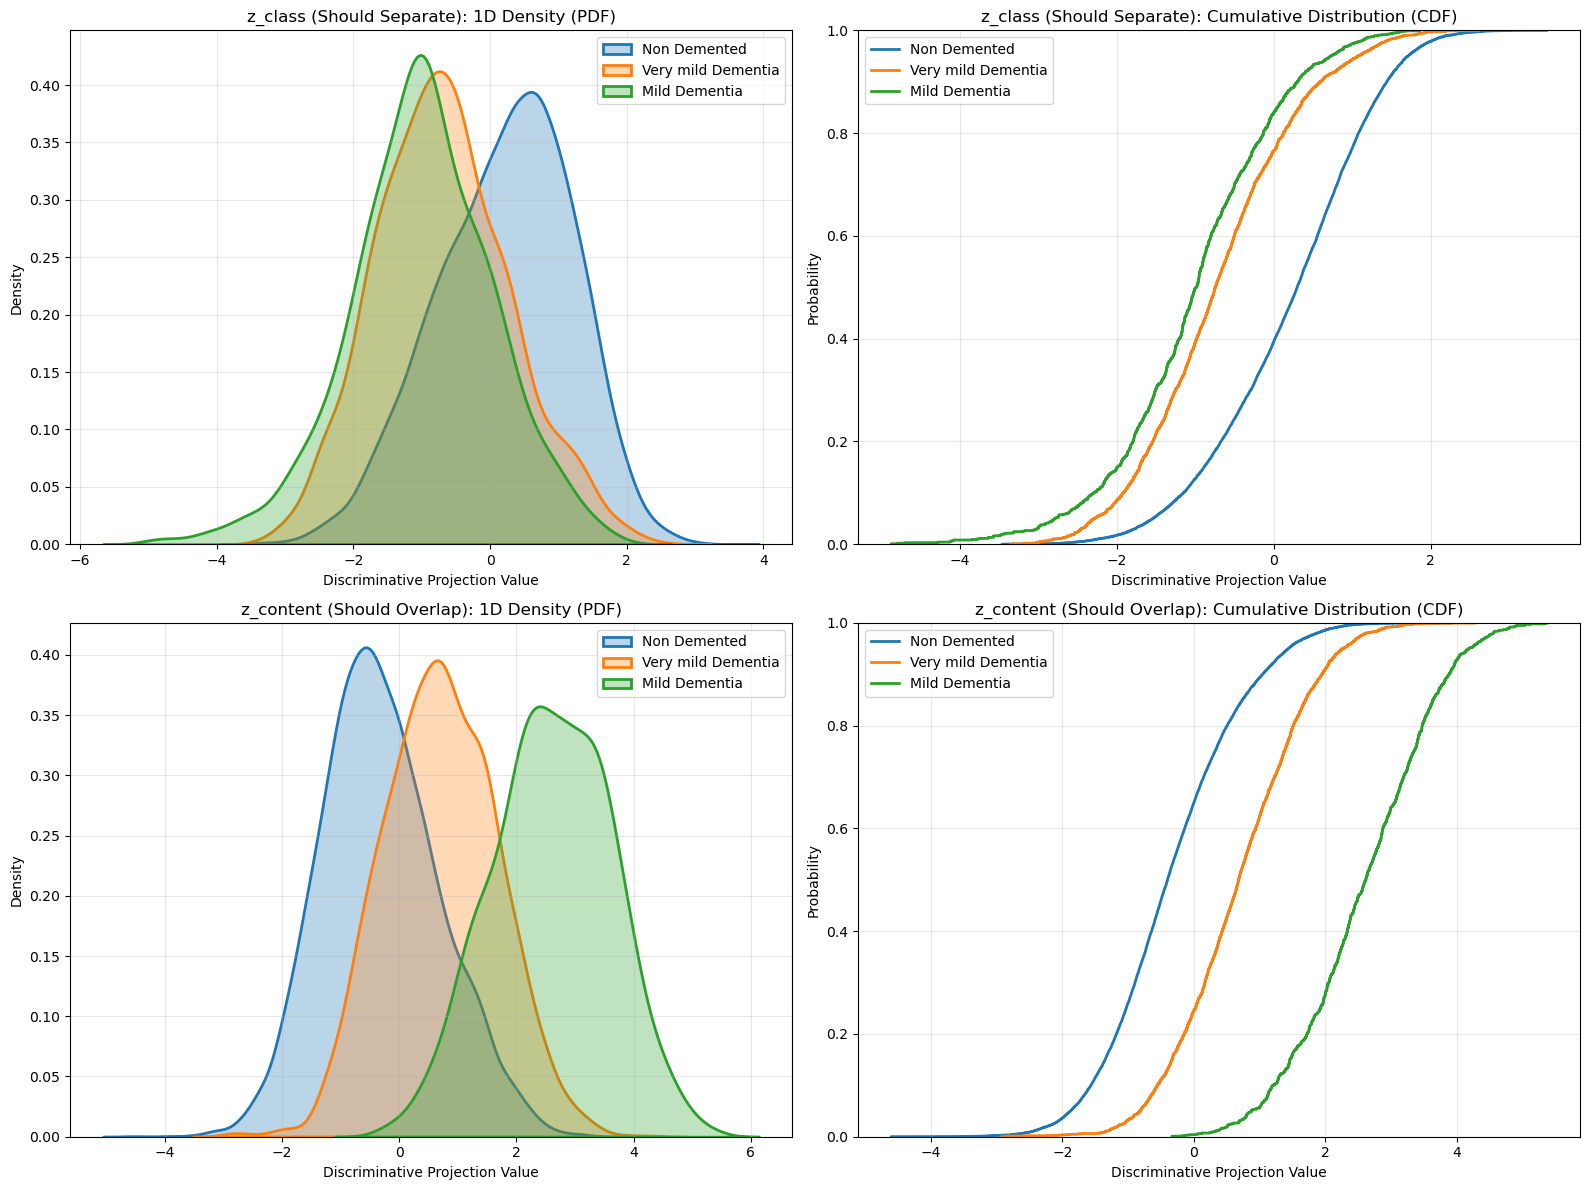

saved distribution plot to GEN_SAMPLES_QUANTIZATION_HYPERPARAMETER/latent_distributions_1d.png


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import StandardScaler

def visualize_1d_overlap(model, loader, device):
    """
    Generates 1D PDF and CDF plots to visualize class overlap/separation.
    Uses LDA to project high-dim latents onto the most discriminative 1D axis.
    """
    model.eval()
    
    z_content_list = []
    z_class_list = []
    labels_list = []

    
    
    print("[Visualization] Extracting latents for distribution analysis...")
    with torch.no_grad():
        for x, y, _ in tqdm(loader, desc="Encoding"):
            x = x.to(device)
            y = y.to(device)
            
                        ## Get model output
            outputs = model(x, y)

            # Handle different return signatures dynamically
            if len(outputs) == 7:
                # Quantized CVAE: out, mu, logv, z_content, z_class_raw, q_loss, c_loss
                _, _, _, z_content, z_class_raw, _, _ = outputs
            elif len(outputs) == 5:
                # Vanilla CVAE: out, mu, logv, z_content, z_class_raw
                _, _, _, z_content, z_class_raw = outputs
            else:
                raise ValueError(f"Unexpected model output length: {len(outputs)}")
                        
            z_content_list.append(z_content.cpu().numpy())
            z_class_list.append(z_class_raw.cpu().numpy())
            labels_list.append(y.cpu().numpy())
            
    Z_content = np.concatenate(z_content_list, axis=0)
    Z_class = np.concatenate(z_class_list, axis=0)
    Y = np.concatenate(labels_list, axis=0)
    
    class_names = [CLASSES[i] for i in range(NUM_CLASSES)]
    
    # --- Helper to project and plot ---
    def plot_distributions(data, title_prefix, ax_pdf, ax_cdf):
        # 1. Project to 1D using LDA (Maximal Separation)
        # We want to see the 'best case' separation. If LDA can't separate them, nothing can.
        lda = LinearDiscriminantAnalysis(n_components=1)
        scaler = StandardScaler()
        data_scaled = scaler.fit_transform(data)
        
        # Fit LDA
        # Note: LDA requires at least 2 classes.
        z_projected = lda.fit_transform(data_scaled, Y).flatten()
        
        # 2. Plot PDF (KDE)
        for c in range(NUM_CLASSES):
            sns.kdeplot(
                z_projected[Y == c], 
                fill=True, 
                label=class_names[c], 
                alpha=0.3, 
                linewidth=2,
                ax=ax_pdf
            )
        ax_pdf.set_title(f"{title_prefix}: 1D Density (PDF)")
        ax_pdf.set_xlabel("Discriminative Projection Value")
        ax_pdf.set_ylabel("Density")
        ax_pdf.legend()
        ax_pdf.grid(True, alpha=0.3)
        
        # 3. Plot CDF
        for c in range(NUM_CLASSES):
            sns.ecdfplot(
                z_projected[Y == c], 
                label=class_names[c], 
                linewidth=2,
                ax=ax_cdf
            )
        ax_cdf.set_title(f"{title_prefix}: Cumulative Distribution (CDF)")
        ax_cdf.set_xlabel("Discriminative Projection Value")
        ax_cdf.set_ylabel("Probability")
        ax_cdf.legend()
        ax_cdf.grid(True, alpha=0.3)

    # --- Create Figure ---
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Row 1: z_class (We WANT separation here)
    plot_distributions(Z_class, "z_class (Should Separate)", axes[0, 0], axes[0, 1])
    
    # Row 2: z_content (We WANT overlap here)
    plot_distributions(Z_content, "z_content (Should Overlap)", axes[1, 0], axes[1, 1])
    
    plt.tight_layout()
    save_path = os.path.join(OUTPUT_FOLDER, "latent_distributions_1d.png")
    plt.savefig(save_path, dpi=150)
    plt.show()
    print(f"saved distribution plot to {save_path}")

# Run the visualization
visualize_1d_overlap(model, val_loader, DEVICE)

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import timm
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms

In [5]:
ANALYSIS_MEAN = torch.tensor([0.456]).view(1,1,1).to(DEVICE)
ANALYSIS_STD  = torch.tensor([0.224]).view(1,1,1).to(DEVICE)

CLASSES = {0:'Non Demented',1:'Very mild Dementia',2:'Mild Dementia'}

In [6]:
# ----------------------------------------------------------
# 1) Classification Model
# ----------------------------------------------------------
class PretrainedClassifier(nn.Module):
    def __init__(self, model_name='resnet18', num_classes=3, in_chans=1):
        super().__init__()
        self.model = timm.create_model(
            model_name,
            pretrained=False,
            num_classes=num_classes,
            in_chans=in_chans
        )

    def forward(self, x):
        return self.model(x)

def load_generated_image(path):
    img = Image.open(path).convert("L")
    img = transforms.ToTensor()(img)   # shape [1,224,224]
    return img

def load_classifier(model_path):
    model = PretrainedClassifier().to(DEVICE)
    state = torch.load(model_path, map_location=DEVICE)
    model.load_state_dict(state, strict=False)
    model.eval()
    return model


# ----------------------------------------------------------
# 2) Grad-CAM
# ----------------------------------------------------------
feature_map = None

def forward_hook(module, input, output):
    global feature_map
    feature_map = output
    feature_map.retain_grad()

def get_gradcam(model, img_norm, target_class):
    global feature_map
    feature_map = None

    target_layer = model.model.layer4
    hook = target_layer.register_forward_hook(forward_hook)

    out = model(img_norm.unsqueeze(0))

    if target_class is None:
        target_class = out.argmax(1).item()

    model.zero_grad()
    out[0, target_class].backward()

    hook.remove()

    fmap = feature_map.detach().cpu().numpy()[0]
    grad = feature_map.grad.detach().cpu().numpy()[0]

    weights = np.mean(grad, axis=(1,2))

    cam = np.zeros(fmap.shape[1:], dtype=np.float32)
    for c, w in enumerate(weights):
        cam += w * fmap[c]

    cam = np.maximum(cam, 0)
    cam = cv2.resize(cam, (img_norm.size(2), img_norm.size(1)))
    cam -= cam.min()
    cam /= cam.max() + 1e-7
    return cam


# ----------------------------------------------------------
# 3) Visualization
# ----------------------------------------------------------
def visualize_gradcam(original_img_01, cam, pred_name, save_path):
    img = original_img_01.squeeze().cpu().numpy()

    heatmap = cv2.applyColorMap(np.uint8(cam*255), cv2.COLORMAP_JET)
    heatmap = heatmap[:, :, ::-1] / 255.0

    img3 = np.stack([img, img, img], axis=-1)
    overlay = 0.4*heatmap + 0.6*img3
    overlay = np.uint8(overlay*255)

    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.imshow(img, cmap='gray')
    plt.title("Generated Image")
    plt.axis("off")

    plt.subplot(1,2,2)
    plt.imshow(overlay)
    plt.title(f"Grad-CAM ({pred_name})")
    plt.axis("off")   

    plt.subplots_adjust(wspace=0.05)
    plt.tight_layout()
    plt.savefig(save_path)
    plt.close()
    print(f"Saved Grad-CAM image: {save_path}")


# ----------------------------------------------------------
# 4) Main Runner (생성 이미지 전용)
# ----------------------------------------------------------
def run_gradcam_on_generated_image(gen_img_tensor, classifier_path):

    # load classifier
    clf = load_classifier(classifier_path)

    # normalize
    img_norm = (gen_img_tensor.to(DEVICE) - ANALYSIS_MEAN) / ANALYSIS_STD

    # classification
    with torch.no_grad():
        logits = clf(img_norm.unsqueeze(0))
        pred_id = logits.argmax(1).item()
        pred_name = CLASSES[pred_id]

    print(f"Predicted class: {pred_name}")

    # compute grad-cam
    cam = get_gradcam(clf, img_norm, pred_id)

    # save visualization
    visualize_gradcam(
        original_img_01=gen_img_tensor.cpu(),
        cam=cam,
        pred_name=pred_name,
        save_path=f"gradcam_generated__quantization__hyperparameter_{pred_name}.png"
    )


# ----------------------------------------------------------
# 5) 🔥 실제 호출
# ----------------------------------------------------------
# CVAE에서 생성한 이미지를 gen_img 라고 가정
# gen_img shape: [1, 224, 224]

# 예)
# gen,_,_,_ = model(x0, proto)
# gen_img = gen.squeeze(0)

# 🔥 실제 실행 코드
gen_img = load_generated_image("GEN_SAMPLES_QUANTIZATION_HYPERPARAMETER/from_Very mild Dementia_to_Mild Dementia_1620.png")
    
run_gradcam_on_generated_image(
    gen_img_tensor = gen_img, 
    classifier_path = "/home/juhyeong/AML/best_classifier_resnet18_weights_42.pth"
)

Predicted class: Mild Dementia
Saved Grad-CAM image: gradcam_generated__quantization__hyperparameter_Mild Dementia.png


In [ ]:
import torch
import numpy as np
from torch.utils.data import DataLoader
from tqdm import tqdm
import torch.nn.functional as F 

# ----------------------------------------------------
# 1) Intra-class variance of z_class_raw
# ----------------------------------------------------
@torch.no_grad()
def compute_intra_class_variance(model, loader):
    print("\n[1] Computing intra-class variance of z_class ...")
    model.eval()
    zs = {c: [] for c in range(NUM_CLASSES)}

    for x, y, _ in tqdm(loader):
        x = x.to(DEVICE)
        y = y.to(DEVICE)
        _, _, _, z_content, z_class_raw = model(x, y)

        z_class_norm = F.normalize(z_class_raw, dim=1)

        for zi, yi in zip(z_class_raw, y):
            zs[int(yi.item())].append(zi.cpu().numpy())

    variances = {}
    for c in zs:
        arr = np.stack(zs[c])
        variances[c] = np.mean(np.var(arr, axis=0))

    return variances


# ----------------------------------------------------
# 2) Center-to-center distance
# ----------------------------------------------------
def compute_center_distances(cluster_loss_fn):
    print("\n[2] Computing center distances ...")

    # 1) torch tensor로 꺼내기
    centers = cluster_loss_fn.centers.detach().cpu()

    # 2) ★ L2-norm normalize 적용
    centers = F.normalize(centers, dim=1)

    # 3) numpy 변환
    centers = centers.numpy()

    dists = {}
    for i in range(NUM_CLASSES):
        for j in range(i + 1, NUM_CLASSES):
            d = np.linalg.norm(centers[i] - centers[j])
            dists[f"{CLASSES[i]} vs {CLASSES[j]}"] = d

    avg_dist = np.mean(list(dists.values()))
    return avg_dist, dists


# ----------------------------------------------------
# MAIN
# ----------------------------------------------------
if __name__ == "__main__":

    # ===== Validation dataset =====
    val_dataset = OASISContrastiveDataset("/home/juhyeong/AML/Data", transform=transform, split='val')
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)

    # ===== Load trained CVAE =====
    print("\nLoading trained CVAE ...")
    model = ImprovedCVAE(
        LATENT_DIM, IMAGE_SIZE, IMAGE_CHANNEL,
        num_classes=NUM_CLASSES
    ).to(DEVICE)

    ckpt = torch.load(CVAE_MODEL_PATH, map_location=DEVICE)
    model.load_state_dict(ckpt["model"])
    print(f"✔ Loaded model (epoch {ckpt['epoch']} | val_loss {ckpt['val_loss']:.4f})")

    # ===== Load trained centers =====
    print("Loading trained class centers ...")
    cluster_loss_fn = ImprovedClusteringLoss(
        latent_dim=model.cls_dim,
        num_classes=NUM_CLASSES,
        margin=MARGIN
    ).to(DEVICE)
    cluster_loss_fn.load_state_dict(ckpt["cluster"])
    print("✔ Loaded centers")

    # ===== Compute metrics =====
    intra_var = compute_intra_class_variance(model, val_loader)
    avg_dist, dist_dict = compute_center_distances(cluster_loss_fn)

    # ===== Print results =====
    print("\n==================== Results ====================")
    print("Intra-class variance (mean):")
    for c, v in intra_var.items():
        print(f"  {CLASSES[c]}: {v:.4f}")

    print("\nPairwise center distances:")
    for pair, dist in dist_dict.items():
        print(f"  {pair}: {dist:.4f}")

    print(f"\nAverage center distance = {avg_dist:.4f} (margin={MARGIN})")
    print("=================================================\n")

In [7]:
import torch
import numpy as np
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# -----------------------------
# Config
# -----------------------------
CVAE_MODEL_PATH = "/home/juhyeong/AML/best_cvae_quantization_hyperparameter.pth"
BATCH_SIZE = 32
NUM_CLASSES = len(CLASSES)

# -----------------------------
# Load dataset
# -----------------------------
test_dataset = OASISContrastiveDataset(DATA_DIR, transform=transform, split='val')
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# -----------------------------
# Load CVAE
# -----------------------------
model = ImprovedCVAE(
    latent_dim=LATENT_DIM,
    img_size=224,
    img_channel=1,
    num_classes=NUM_CLASSES
).to(DEVICE)

ckpt = torch.load(CVAE_MODEL_PATH, map_location=DEVICE)
model.load_state_dict(ckpt["model"])
model.eval()

print(f"Loaded CVAE checkpoint (epoch {ckpt['epoch']}, val_loss={ckpt['val_loss']:.4f})")

# -----------------------------
# Collect latent vectors
# -----------------------------
lat_z_content = []
lat_z_class = []
labels = []

with torch.no_grad():
    for x, y, _ in test_loader:
        x = x.to(DEVICE)
        y = y.to(DEVICE)
        
        # recon, mu, logv, z_content, z_class_raw
        _, _, _, zc, zcls, _, _ = model(x, y)

        lat_z_content.append(zc.cpu())
        lat_z_class.append(zcls.cpu())
        labels.append(y.cpu())

lat_z_content = torch.cat(lat_z_content).numpy()
lat_z_class = torch.cat(lat_z_class).numpy()
labels = torch.cat(labels).numpy()

print("z_content shape:", lat_z_content.shape)
print("z_class_raw shape:", lat_z_class.shape)

# -----------------------------
# dimensionality reduction utils
# -----------------------------

def plot_2d(feats, labels, title, save_path):
    plt.figure(figsize=(7, 6))
    for cls_id, cls_name in CLASSES.items():
        idx = labels == cls_id
        plt.scatter(
            feats[idx, 0],
            feats[idx, 1],
            s=10, alpha=0.7,
            label=cls_name
        )
    plt.legend()
    plt.title(title)
    plt.tight_layout()
    plt.savefig(save_path, dpi=120)
    plt.close()
    print(f"Saved: {save_path}")

# -----------------------------
# PCA
# -----------------------------
pca = PCA(n_components=2)
pca_zc = pca.fit_transform(lat_z_content)
pca_zcls = pca.fit_transform(lat_z_class)

plot_2d(pca_zc, labels, "PCA of z_content", "pca_z_content_quantization_hyperparameter.png")
plot_2d(pca_zcls, labels, "PCA of z_class", "pca_z_class_quantization_hyperparameter.png")

# -----------------------------
# t-SNE
# -----------------------------
tsne = TSNE(n_components=2, learning_rate="auto", init="random")

tsne_zc = tsne.fit_transform(lat_z_content)
tsne_zcls = tsne.fit_transform(lat_z_class)

plot_2d(tsne_zc, labels, "t-SNE of z_content", "tsne_z_content_quantization_hyperparameter.png")
plot_2d(tsne_zcls, labels, "t-SNE of z_class", "tsne_z_class_quantization_hyperparameter.png")

print("Done. Saved PCA & t-SNE plots.")

Loaded CVAE checkpoint (epoch 2, val_loss=1.9296)
z_content shape: (16653, 96)
z_class_raw shape: (16653, 32)
Saved: pca_z_content_quantization_hyperparameter.png
Saved: pca_z_class_quantization_hyperparameter.png
Saved: tsne_z_content_quantization_hyperparameter.png
Saved: tsne_z_class_quantization_hyperparameter.png
Done. Saved PCA & t-SNE plots.


In [ ]:
print("Training and generation complete. Restarting kernel...")
%reset -f